In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.special import legendre
from scipy.integrate import simpson

In [2]:
class AtTemp:
    def __init__(self, a, N, omega_0, matsubara, ng2, T):
        self.a = a
        self.N = N
        self.omega_0 = omega_0
        self.matsubara = matsubara
        self.ng2 = ng2
        self.T = T
        self.omega = self.omega_matsu()
        self.lambda_iso = self.val_lambda()
        self.theta = self.theta_array()
        self.zz = self.Z()
        self.integration = self.phi_integration_simpson()
        self.matrix = self.cal_matrix()
        self.eigenvalues = self.eigenvalue_prob()
        self.largest_eigenvalue = self.max_eigenvalue()


    def omega_matsu(self):
        omega = np.asarray([(2 * (-(self.matsubara/2) + i) + 1) * np.pi * self.T for i in range(self.matsubara)]) # matsubara frequencies
        return omega
    
    def val_lambda(self):
        lambda_iso = np.asarray(
            [
                [
                    2
                    * self.omega_0
                    * self.ng2
                    / (np.square(self.omega[i] - self.omega[j]) + np.square(self.omega_0))
                    for j in range(len(self.omega))
                ]
                for i in range(len(self.omega))
            ]
        )
        return lambda_iso
    
    def theta_array(self):
        theta = np.linspace(0, np.pi, self.matsubara)
        return theta
    """
    def Z(self):
        X = (self.omega / np.abs(self.omega)) * self.lambda_iso
        zz = 1 + (self.T/(8*self.omega)) * (1 + self.a* (legendre(self.N)(np.cos(self.theta))) ) *  4*np.pi * np.sum(X, axis=1)
        return zz
    """
    
    def Z(self):
        sigma_n = np.sum((self.omega / np.abs(self.omega)) * self.lambda_iso, axis=1)
        matrix = np.zeros((len(self.theta), len(sigma_n)))
        for i in range(len(self.theta)):
            legendre_val = legendre(self.N)(np.cos(self.theta[i]))
            for j in range(len(sigma_n)):
                matrix[i, j] = 1 + (np.pi*self.T/(self.omega[j])) * (1 + self.a * legendre_val) * sigma_n[j]
        return matrix
    """
    def phi_integration_simpson(self): 
        denominator = self.zz
        numerator = (1 + self.a * (legendre(self.N)(np.cos(self.theta))) )**2
        sub_integrand = np.divide(numerator, denominator)
        integrand = np.sin(self.theta) * 2*np.pi * sub_integrand
        integration = integrate.simpson(integrand, self.theta)
        return integration
    """
    def phi_integration_simpson(self):
        Zz = self.zz
        integration_list = []
        for i in range(Zz.shape[1]):
            denominator = Zz[:, i]
            numerator = (1 + self.a * (legendre(self.N)(np.cos(self.theta))) )**2 
            sub_integrand = np.divide(numerator, denominator) # for this step we know it will work when len(thera) = len(omega). But what when it doesn't?
            integrand = np.sin(self.theta) * sub_integrand
            integrated_element = integrate.simpson(integrand, self.theta)
            integration_list.append(integrated_element)
        integration = np.array(integration_list)
        return integration   
    
    def cal_matrix(self):
        k_matrix = self.T/8 * self.lambda_iso * self.integration 
        matrix = np.divide(k_matrix, np.abs(self.omega))
        return matrix
    
    def eigenvalue_prob(self):
        eigenvalues, _ = np.linalg.eig(self.matrix)
        return eigenvalues
    
    def max_eigenvalue(self):
        return np.max(self.eigenvalues)

In [3]:
class ForAvalue(AtTemp):
        def __init__(self, a, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps):
        # Initialize with the first value of T to reuse the calculation methods
                super().__init__(a, N, omega_0, matsubara, ng2, T_start) # initialize the parent class
                self.eignevalue_limit = eignevalue_limit
                self.T_start = T_start
                self.T_steps = T_steps
                self.T_values, self.eigenvalues = self.iter_over_t()

        def iter_over_t(self):
                eigenvalues = []
                T_values = []
                eigenvalues.append(self.largest_eigenvalue)
                T_values.append(self.T_start)
                if self.largest_eigenvalue > self.eignevalue_limit:
                    while self.largest_eigenvalue > self.eignevalue_limit:
                        self.T_start += self.T_steps
                        super().__init__(self.a, self.N, self.omega_0, self.matsubara, self.ng2, self.T_start)
                        eigenvalues.append(self.largest_eigenvalue)
                        T_values.append(self.T_start)
                        #print(f"The eigenvalue is {self.largest_eigenvalue} for T = {self.T_start}")
                else:
                      print("The eigenvalue is already smaller than 1")

                return T_values, eigenvalues

                

In [4]:
omega_0 = 0.05 # phonon frequency
ng2 = 0.0144 # coupling strength?

#T = 0.00014
matsubara = 200
a = 0.1
N = 2

eignevalue_limit = 0.7
T_start = 0.00014
T_steps = 0.00001

In [5]:
a, N, omega_0, matsubara, ng2, T_start, T_steps, eignevalue_limit

(0.1, 2, 0.05, 200, 0.0144, 0.00014, 1e-05, 0.7)

In [6]:
att = ForAvalue(a, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps)


In [8]:
largest_eigenvalue = np.max(att.eigenvalues)
print(f"The largest eigenvalue is {largest_eigenvalue} for T = {T_start}")

The largest eigenvalue is (1.3633633675351133+0j) for T = 0.00014


/home/pawanprakash/miniconda3/envs/anisotel/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


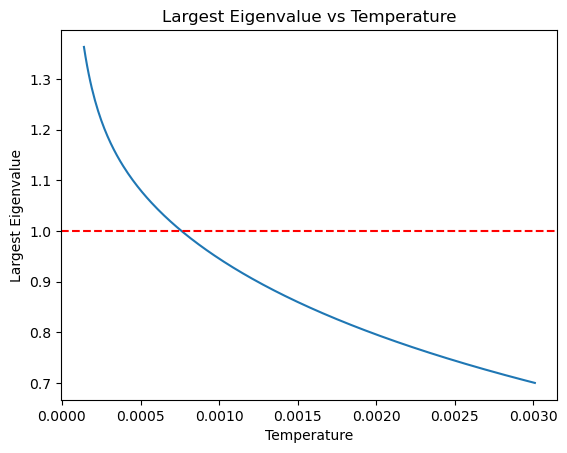

In [9]:
import matplotlib.pyplot as plt
plt.plot(att.T_values, att.eigenvalues)
plt.xlabel('Temperature')
plt.ylabel('Largest Eigenvalue')
plt.title('Largest Eigenvalue vs Temperature')
# Add a horizontal line at y=1
plt.axhline(y=1.0, color='r', linestyle='--')
plt.show()